# Takeaways
* `data['p'] = data['p'].shift(1) # Move data backwards a day to avoid foresign bias`
* Double axis one liner: `data.plot(figsize=(20,12), secondary_y='p')`
* Implement this strat: `data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(20, 12))`
* Transaction costs: `sum(data['p'].diff() != 0) + 2 # The number of times position switches`
* Transaction cost implementation: `# Lower returns by transaction cost whenever a switch happens data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])`


# Intro
* This covers exploiting economic efficiencies (a subset of statistical inefficiencies)
* This follows a 3 step process - **Training, Risk Management, and Deployment**

# Types of Algorithms
* **Liquidity Management**: Execute orders as cheaply as possible.
* **Replicate the payoff of Derivative Instruments**: Dynamic hedging/replication
* **Alpha**: Exploit statistical inefficiencies to make money

# Backtesting
* It is crucial to get large market movements right as well as small ones
* Next, demonstrating some backtesting approaches on the EUR/USD currency pair

In [43]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt
import random
import tensorflow.compat.v1 as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
tf.compat.v1.logging.set_verbosity('ERROR')
from sklearn.metrics import accuracy_score

plt.style.use('seaborn')
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
symbol = 'EUR='

In [8]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
EUR=    2516 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


In [10]:
# Standard SMA cross long/short strategy
data['SMA1'] = data[symbol].rolling(42).mean()
data['SMA2'] = data[symbol].rolling(258).mean()

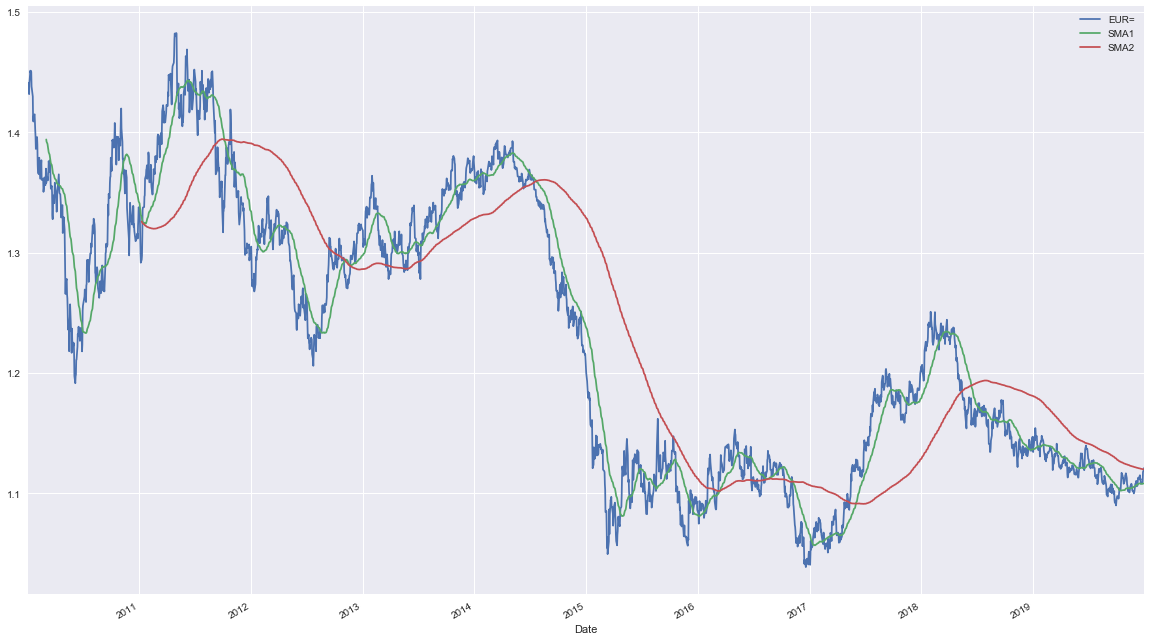

In [11]:
data.plot(figsize=(20,12))

In [12]:
data.dropna(inplace=True)

In [14]:
# Derive a strategy long where SMA1 is above SMA2, short otherwise
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['p'] = data['p'].shift(1) # Move data backwards a day to avoid foresign bias
data.dropna(inplace=True)

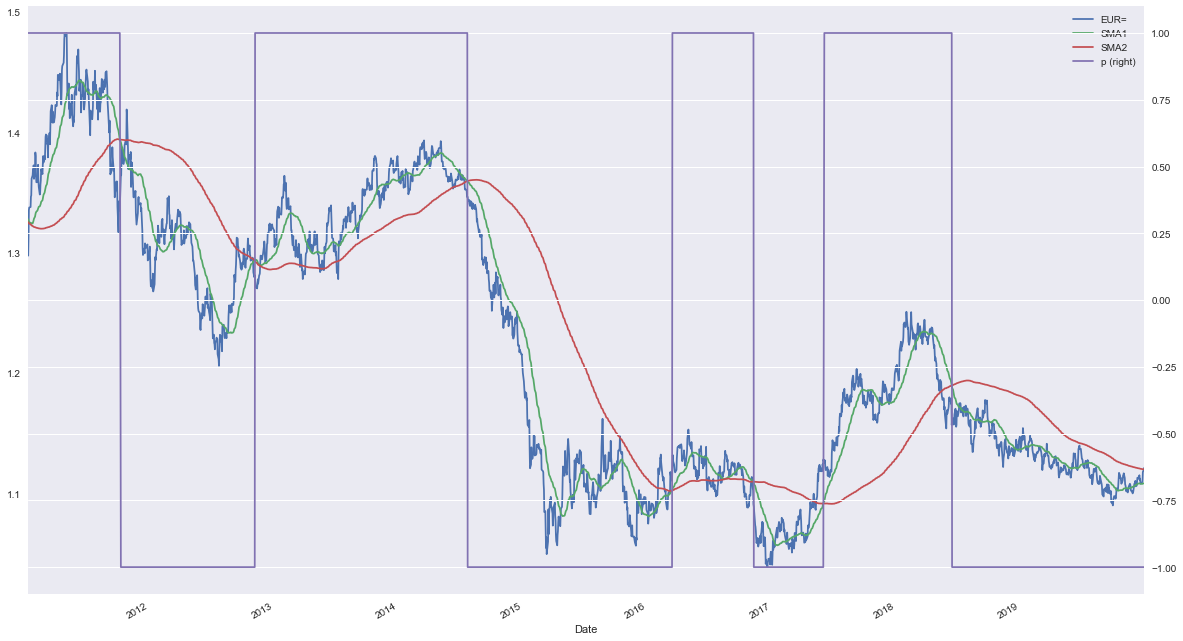

In [16]:
data.plot(figsize=(20,12), secondary_y='p')

In [17]:
# Now add in returns on this and we have the strategy
data['r'] = np.log(data[symbol]/data[symbol].shift(1))
data.dropna(inplace=True)

In [18]:
data['s'] = data['r'] * data['p'] # This makes the returns happen

In [21]:
data[['r', 's']].sum().apply(np.exp) # Cumulative gross instrument returns and strat returns

r   0.8640
s   1.3773
dtype: float64

In [22]:
data[['r', 's']].sum().apply(np.exp) - 1 # Net Returns

r   -0.1360
s    0.3773
dtype: float64

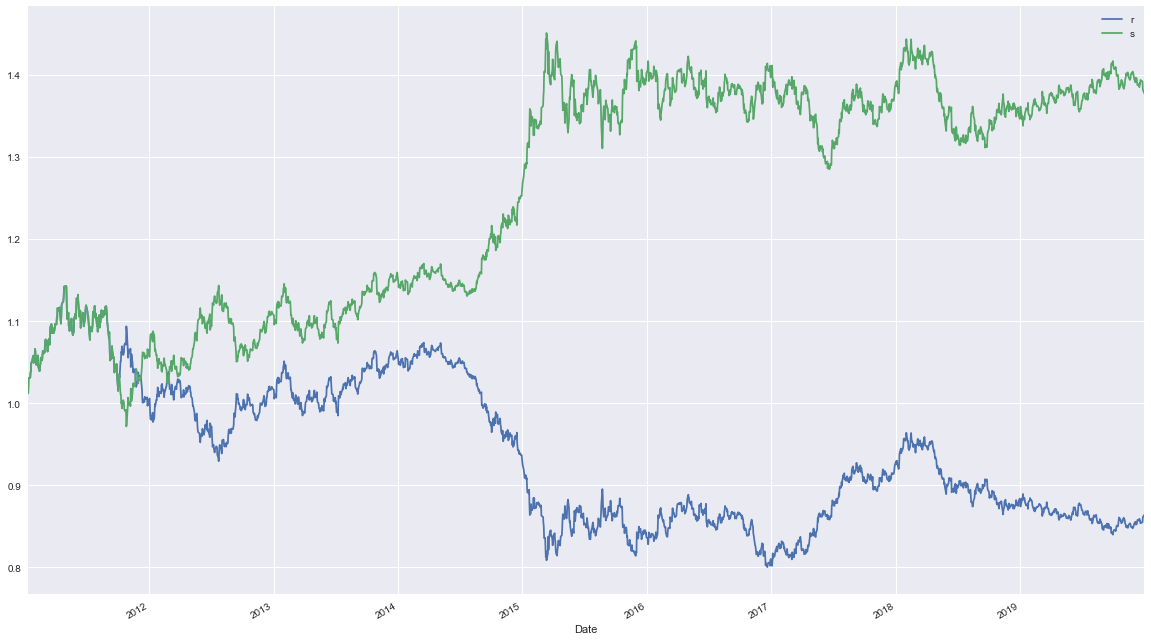

In [23]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(20, 12))

In [24]:
'''
Now add in trading costs - compute when the trade takes place and use the number of position switches *
50bps (arbitrary number, aiming high)
''' 
sum(data['p'].diff() != 0) + 2 # The number of times position switches

10

In [25]:
pc = 0.005 # Percentage of cost

In [26]:
# Lower returns by transaction cost whenever a switch happens
data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])

In [28]:
data['s_'].iloc[0] -= pc # Adjust for entry and exit trade
data['s_'].iloc[-1] -= pc

In [29]:
data[['r', 's', 's_']].sum().apply(np.exp)

r    0.8640
s    1.3773
s_   1.2971
dtype: float64

In [31]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1 # Losing 8% of alpha to transaction costs

r    -0.1360
s     0.3773
s_    0.2971
dtype: float64

# Volatility
* For a strategy that is simply long or short the benchmark instrument, the volatility is exactly the same as that of the benchmark instrument

In [32]:
data[['r', 's', 's_']].std() # Daily Volatility

r    0.0054
s    0.0054
s_   0.0054
dtype: float64

In [34]:
data[['r', 's', 's_']].std() * math.sqrt(252) # Annualized Volatility

r    0.0853
s    0.0853
s_   0.0855
dtype: float64

# Backtesting Deep Neural Networks

In [35]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
EUR=    2516 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


In [37]:
lags = 5

In [40]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags+1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [41]:
data, cols = add_lags(data, symbol, 5, window=20)

In [44]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.compat.v1.random.set_random_seed(seed)
set_seeds()

In [45]:
optimizer = Adam(learning_rate=0.0001)

In [47]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3, regularize=False, reg=l1(0.0005), optimizer=optimizer,
                input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim, activity_regularizer=reg), activation='relu')
    
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', activity_regularizer=reg))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Test-Train-Split this model
split = '2018-'